In [1]:
import importlib
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

In [2]:
os.chdir(os.getcwd() + '/src/')
os.getcwd()
import utils as utils
import gmm as GMM

In [13]:
test_rng: np.random.Generator = np.random.default_rng(0)
k = 2
dim = 2
gamma = 0.01

def reload():
    importlib.reload(GMM)
    importlib.reload(utils)

[[3.99572838 3.75236544]
 [3.69950663 3.57134308]]


<AxesSubplot:>

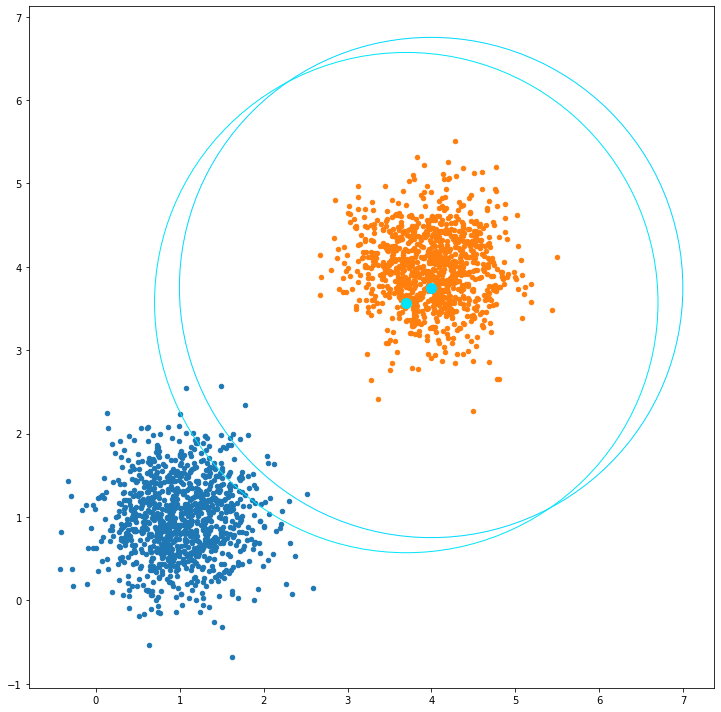

In [14]:
cluster_means = [
    [1, 1],
    [4, 4],
]
initial_data, fig, ax = utils.generate_clustered_data(dim, k, cluster_means, num_points_per_cluster=1000, plot=True, spread_factor=0.05)
shuffle_data = test_rng.permutation(initial_data)
gmm_init_data = shuffle_data[:k]
print(gmm_init_data)
gmm = GMM.GMM(0, 2)
gmm.initialize(gmm_init_data)
utils.plot_gaussians(gmm.means, gmm.covariances, ax)

In [5]:
gmm.log_likelihood(shuffle_data)

-12550.03697953886

In [7]:
nb_iter = 10
batch_size = 100
gamma = 0.01
gmm.set_gamma(gamma)
for i in range(nb_iter):
    print(f'Current ll {gmm.log_likelihood(shuffle_data)}.')
    samples = shuffle_data[test_rng.choice(len(shuffle_data), size=batch_size)]
    print(f'Coefficients are {gmm.coefficients}; Means are {gmm.means}')
    print(f'Maxima in covs are {[np.max(c) for c in gmm.covariances]}')
    samples = shuffle_data[test_rng.choice(len(shuffle_data), size=batch_size)]
    before = gmm.log_likelihood(samples)
    gmm.online_EM(samples)
    after = gmm.log_likelihood(samples)
    print(f'--------- ll shifted from {before} to {after} ----------')

Current ll -12550.03697953886.
Coefficients are [0.5 0.5]; Means are [[3.49343183 4.48720422]
 [3.62476771 3.9921063 ]]
Maxima in covs are [1.0, 1.0]
--------- ll shifted from -624.5389775035899 to -291.4470721256664 ----------
Current ll -6182.906345749108.
Coefficients are [0.45471484 0.54528516]; Means are [[2.33575987 2.98006983]
 [3.30325768 3.31540838]]
Maxima in covs are [2.782105519195761, 1.6444071180945496]
--------- ll shifted from -319.03209724336375 to -289.5964574975462 ----------
Current ll -5738.856255318658.
Coefficients are [0.41914737 0.58085263]; Means are [[1.77533986 2.35670567]
 [3.3000257  3.10793159]]
Maxima in covs are [2.4430433420881843, 1.9434400314569311]
--------- ll shifted from -287.27726186863225 to -281.0037366079609 ----------
Current ll -5692.2195021832495.
Coefficients are [0.43797443 0.56202557]; Means are [[1.47129415 1.97924143]
 [3.32824429 3.07954325]]
Maxima in covs are [1.8634156413138692, 1.8525837778260046]
--------- ll shifted from -273.9

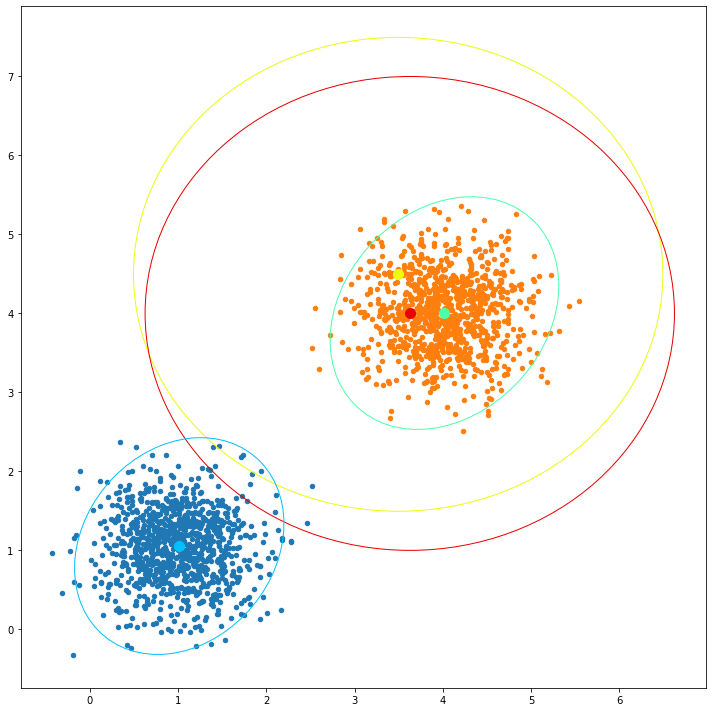

In [8]:
utils.plot_gaussians(gmm.means, gmm.covariances, ax)
fig

## TEST GMM IN HIGHER DIMENSIONS

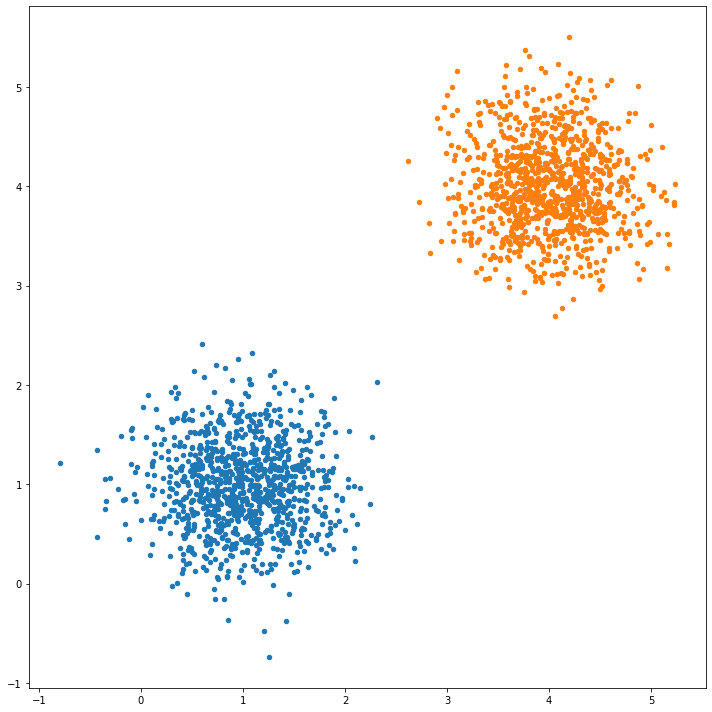

In [15]:
import tqdm
test_rng: np.random.Generator = np.random.default_rng(0)
cluster_means = [
    [1, 1],
    [4, 4],
]
initial_data, fig, ax = utils.generate_clustered_data(dim, k, cluster_means, num_points_per_cluster=1000, plot=True, spread_factor=0.05, rng=test_rng)
shuffle_data = test_rng.permutation(initial_data)

In [16]:
def concatenate_data(data: np.ndarray) -> np.ndarray:
    data_concat = []
    for i in range(len(data) - 1):
        data_concat.append(np.hstack([data[i], data[i+1]]))
    return np.array(data_concat)

concat_data = concatenate_data(shuffle_data)
concat_data.shape

(1999, 4)

In [17]:
# solve the clustering problem with K-means clustering method
from sklearn.cluster import KMeans

training_data = concat_data
kmeans = KMeans(n_clusters=4, random_state=0).fit(training_data)
# kmeans.labels_
kmeans.cluster_centers_

array([[3.99067223, 4.01228666, 0.9908468 , 0.97920931],
       [0.99190083, 0.97875034, 4.00225422, 3.99798044],
       [3.99182659, 4.00091211, 3.97971219, 4.01581345],
       [0.97994553, 0.99812768, 0.98244776, 0.99618568]])

In [19]:
# solve the clustering problem with the GMM
gmm = GMM.GMM(0, 4)
gmm.set_gamma(gamma)
gmm.initialize(concat_data[:4])
print(gmm.means)
num_iterations = 20
batch_size = 500
# fails with gamma = 0.01
# gamma = 0.01
gamma = 0.05
ll = [gmm.log_likelihood(concat_data)]
i = 0
for _ in tqdm.tqdm(range(num_iterations)):
    samples = concat_data[test_rng.choice(len(concat_data), size=batch_size)]
    gmm.online_EM(samples)
    ll.append(gmm.log_likelihood(concat_data))
    i += 1

[[0.35209585 1.6631099  1.71380809 0.44130742]
 [1.71380809 0.44130742 0.67504939 0.45824195]
 [0.67504939 0.45824195 1.24615729 1.03929885]
 [1.24615729 1.03929885 1.1635392  0.92728161]]


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]


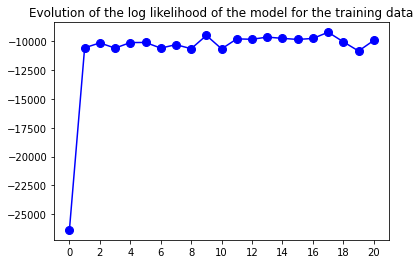

In [20]:
fig, ax = plt.subplots()
color = 'blue'
ax.plot(np.arange(len(ll)), ll, color=color)
for j, l in enumerate(ll):
    ax.plot(j, l, marker='o', markersize=8, markeredgecolor=color, markerfacecolor=color)
ax.set_xticks(np.arange(len(ll), step=2))
ax.set_title('Evolution of the log likelihood of the model for the training data')
print()

In [21]:
print(gmm.means)

[[4.18020872 4.08554324 1.18423551 1.02646636]
 [1.03836713 0.95317107 1.08413041 1.29548481]
 [3.87321943 3.83192238 3.83485521 4.09678712]
 [0.99370394 1.22021285 4.06982591 4.10116083]]


In [22]:
print(kmeans.cluster_centers_)

[[3.99067223 4.01228666 0.9908468  0.97920931]
 [0.99190083 0.97875034 4.00225422 3.99798044]
 [3.99182659 4.00091211 3.97971219 4.01581345]
 [0.97994553 0.99812768 0.98244776 0.99618568]]


Conclusion is that the update parameter $\gamma$ can impede the model's ability to solve the clustering problem.